In [339]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [340]:
import numpy as np
import pandas as pd
df = pd.read_csv('data/export_flat_form.csv')

In [341]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

def split_random(a, n = 0.5):
    msk = np.random.rand(len(a)) < n
    return a[msk].copy(), a[~msk].copy()

def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### Preprocessing
Check info on the events, i.e. date range, plot date distribution to get a clearer view about the data, then drop the date column entirely since it is useless information for our models.

In [342]:
df.date = pd.to_datetime(df["date"])
dates_ordinal = pd.Series([x.toordinal() for x in df.date])

First check the dates and filter the ones that would be too old for us to be usable.

[Text(737200.0, 0, '2019-05-21'),
 Text(737400.0, 0, '2019-12-07'),
 Text(737600.0, 0, '2020-06-24'),
 Text(737800.0, 0, '2021-01-10'),
 Text(738000.0, 0, '2021-07-29')]

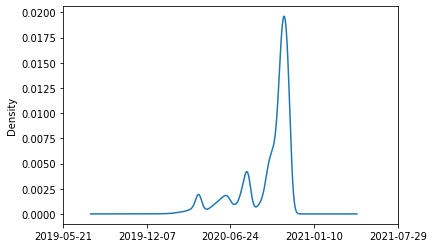

In [343]:
# plot non-parametric kde on numeric datenum
ax = dates_ordinal.plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

let's keep just last 5 months dates

In [344]:
dates_mask = (df.date > '2020-10-01')
df_newer_dates = df.loc[dates_mask]
dates_ordinal_newer = pd.Series([x.toordinal() for x in df_newer_dates.date])

[Text(737660.0, 0, '2020-08-23'),
 Text(737700.0, 0, '2020-10-02'),
 Text(737740.0, 0, '2020-11-11'),
 Text(737780.0, 0, '2020-12-21')]

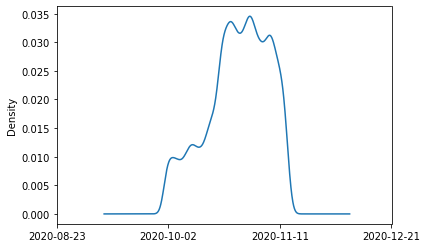

In [345]:
# plot non-parametric kde on numeric datenum
ax = dates_ordinal_newer.plot(kind='kde')
# rename the xticks with labels
x_ticks = ax.get_xticks()
ax.set_xticks(x_ticks[::2])
xlabels = [datetime.datetime.fromordinal(int(x)).strftime('%Y-%m-%d') for x in x_ticks[::2]]
ax.set_xticklabels(xlabels)

In [346]:
min_date = df.date.min()
max_date = df.date.max()
print("older match: "+ str(min_date)+"   newest match: "+str(max_date))

older match: 2020-01-01 00:54:03   newest match: 2020-11-14 12:54:01


In [347]:
min_date = df_newer_dates.date.min()
max_date = df_newer_dates.date.max()
print("older match: "+ str(min_date)+"   newest match: "+str(max_date))

older match: 2020-10-01 00:02:11   newest match: 2020-11-14 12:54:01


In [516]:
sample_size = 35000 #30000

In [517]:
#df_raw = df_newer_dates.drop(columns=['date'])
print(df_newer_dates.shape)
df_raw = df_newer_dates.sample(n = sample_size, random_state = 1, axis = 0)
print(df_raw.shape)
df_raw.reset_index(drop=True, inplace=True)
#print(df_raw.tail())

(45855, 14)
(35000, 14)


In [518]:
invert_ratio = 0.5
#n_inv = int(len(df_raw) * invert_ratio)
df_standard, df_inverted = split_random(df_raw, invert_ratio)
df_inverted = df_inverted.rename(columns={"winnerA": "loserA", "winnerB": "loserB", "winnerC": "loserC", "winnerD": "loserD", "winnerE": "loserE",
                            "loserA": "winnerA", "loserB": "winnerB", "loserC": "winnerC", "loserD": "winnerD", "loserE": "winnerE"})
#df.loc[idx] = df.loc[idx].rename(columns={'R':'L','L':'R'})
df_inverted['outcome'] = 0
df_mixed = df_standard.append(df_inverted)
#but to preserve relevancy to date, need to reorder by date:
df_mixed = df_mixed.sort_values(by='date')
#print(df_mixed.tail())
df_mixed = df_mixed.drop(columns=['date'])
print(df_mixed.outcome.mean())
print(df_mixed.shape)

0.49894285714285713
(35000, 13)


In [519]:
train_cats(df_mixed)
print([len(df_mixed[x].cat.categories) for x in df.columns[1:13]])

[]


### if it throws error here, it means tables were cleared, need to re-run from the import of csv:

In [520]:
hero_names = df_mixed['winnerA'].cat.categories
heroes_total = max(hero_names)
map_names = df_mixed['game_map'].cat.categories

print([len(df_mixed[x].cat.categories) for x in df.columns[1:13]], "  heroes_total =", heroes_total)
print(hero_names[:9], "...")
#df_mixed.dtypes

[]   heroes_total = Zul'jin
Index(['Abathur', 'Alarak', 'Alexstrasza', 'Ana', 'Anduin', 'Anub'arak',
       'Artanis', 'Arthas', 'Auriel'],
      dtype='object') ...


In [521]:
#clear up memory:
dates_ordinal_newer = 0
dates_ordinal = 0
df = pd.DataFrame()
df_raw = pd.DataFrame()
df_standard = pd.DataFrame()
df_inverted = pd.DataFrame()

Great, shuffling worked. Another problem is the format of the table itself. We are more interested in relations between features more than anything else, therefore let's transform the table into something mode understandable for the Tree type model. For that, the first idea to try - split the features into "multiple-hot" encoding table. Not sure if this is even a thing, but let's try that. A one-hot encoder would give us a great start, so let's use that.

In [522]:
winner_cols = ['winnerA', 'winnerB', 'winnerC', 'winnerD', 'winnerE']
loser_cols = ['loserA', 'loserB', 'loserC', 'loserD', 'loserE']
dummies_data = pd.DataFrame(columns = hero_names, dtype = 'int8')

In [523]:
def hero_hot_transform(game_map = '', game_type = 'UnrankedDraft', winners = [], losers = [], bans = []):
    new_row = pd.Series(index = hero_names, dtype = 'int8')
    for x in hero_names:
        if x in winners:
            new_row[x] = 2
        if x in losers:
            new_row[x] = 1
    game_map_index = int(df_mixed['game_map'].cat.categories.get_loc(game_map))
    game_type_index = int(df_mixed['game_type'].cat.categories.get_loc(game_type))

    #print(dict( enumerate(df_mixed['game_map'].cat.categories ) ))
    new_row = new_row.append(pd.Series([game_map_index, game_type_index], index = ['game_map','game_type']))
    return new_row

In [524]:
game_map = 'Garden of Terror'
game_type = 'UnrankedDraft'
winners=['Auriel', 'Muradin']
losers=['Illidian', 'Abathur']
row = [hero_hot_transform(game_map = game_map, game_type=game_type, winners = winners, losers=losers)]

In [525]:
for index in range(0, int(len(df_mixed))): #
    game_map = df_mixed['game_map'].iloc[index]
    game_type = df_mixed['game_type'].iloc[index]

    winners = list(df_mixed[winner_cols].iloc[index].astype(str))
    losers = list(df_mixed[loser_cols].iloc[index].astype(str))
    #bans =
    dummies_data = dummies_data.append(hero_hot_transform(game_map = game_map, game_type=game_type, winners = winners, losers = losers), ignore_index=True)

In [526]:
print('total mem: ', sum(dummies_data.memory_usage()) / 1000)
print(dummies_data.dtypes)

total mem:  24920.128
Abathur          int64
Alarak           int64
Alexstrasza      int64
Ana              int64
Anduin           int64
                ...   
Zarya            int64
Zeratul          int64
Zul'jin          int64
game_map       float64
game_type      float64
Length: 89, dtype: object


In [527]:
dummies_data = pd.concat([dummies_data, df_mixed[['outcome']]], axis = 1)

In [528]:
dummies_data.tail()

,Abathur,Alarak,Alexstrasza,Ana,Anduin,Anub'arak,Artanis,Arthas,Auriel,Azmodan,...,Whitemane,Xul,Yrel,Zagara,Zarya,Zeratul,Zul'jin,game_map,game_type,outcome
34995,0,0,0,0,0,0,0,1,0,1,...,0,2,0,0,0,0,0,3.0,0.0,1
34996,0,0,1,0,0,0,0,0,2,2,...,0,0,0,0,0,0,0,0.0,0.0,0
34997,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,4.0,0.0,1
34998,0,0,0,0,1,0,0,0,0,0,...,0,0,0,2,0,0,0,8.0,0.0,1
34999,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,8.0,1.0,1


## Prepare train and val sets

In [529]:
#need this again for new dataframe, cause we attached strings when transforming
#train_cats(dummies_data)

In [530]:
df_trn, y_trn, nas = proc_df(dummies_data, 'outcome')

In [531]:
train_required_ratio = 0.8
n_trn = int(len(df_trn) * train_required_ratio)
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
X_train.shape, X_valid.shape

((28000, 89), (7000, 89))

In [532]:
apply_cats(X_valid, X_train)

Start with simple and stupid

In [533]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 58.4 ms, sys: 3.88 ms, total: 62.3 ms
Wall time: 117 ms
[0.49953566472571215, 0.5003415560319692, 0.0018556180232627286, -0.0014137776545342096]


In [366]:
#draw_tree(m.estimators_[0], df_trn, size = 20, precision=3)
#?draw_tree

things to try:
max_features = 0.5, 'sqrt', 'log2'
leafs = 1, 3, 5, 10, 25, 50, 100...

In [367]:
#m = RandomForestRegressor(n_estimators=20, min_samples_leaf=3, max_features = 0.2, n_jobs=-1, oob_score=True) #max_features = 1-0.5-0.2, sqrt are good vals
#%time m.fit(X_train, y_train)
#print_score(m)

Well seems like max_features < 1 are not helping, also subsampling doesnt help either.  Let's get back to base mode, with more estimators.

In [368]:
m = RandomForestRegressor(n_estimators=50, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1.34 s, sys: 44 µs, total: 1.34 s
Wall time: 429 ms
[0.19330804432304413, 0.5130734840156915, 0.8505261689455695, -0.053487487944165135]


Would feature importance show hero importance in case if I transformed the table to hero-based?

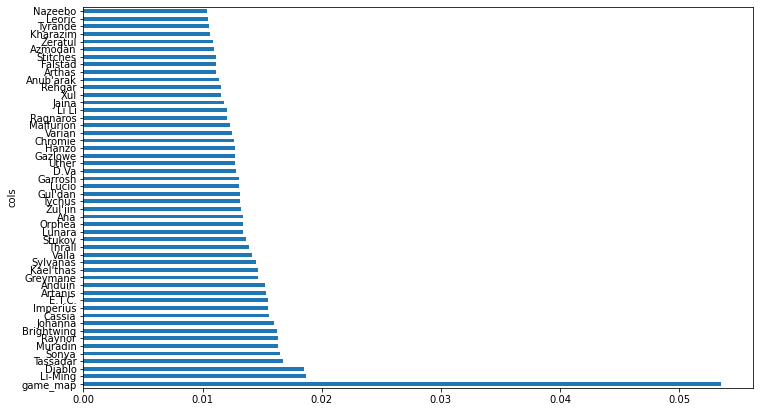

In [369]:
fi = rf_feat_importance(m, df_trn); fi[:10]
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:50]);

In [370]:
#to_keep = fi[fi.imp>0.005].cols; len(to_keep)
#df_keep = df_trn[to_keep].copy()
#X_train, X_valid = split_vals(df_keep, n_trn)

checking how correlated the features are:

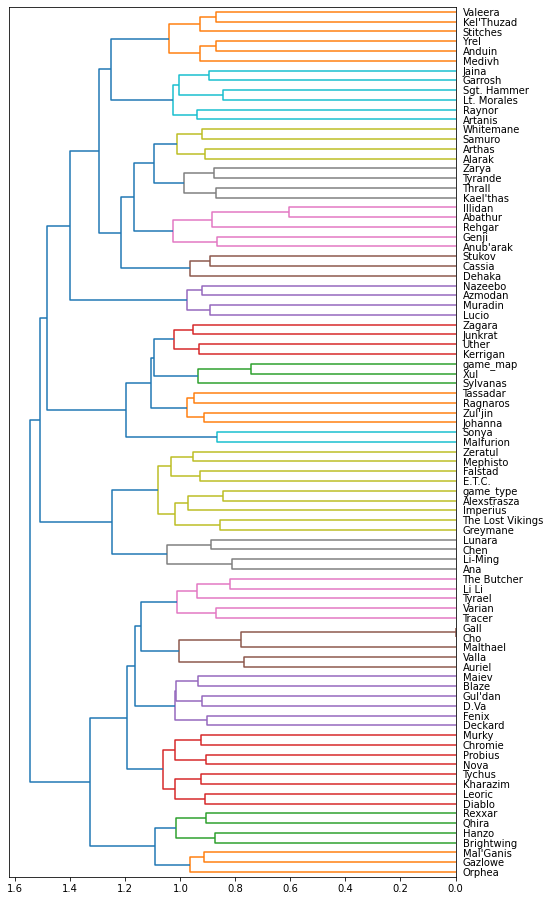

In [371]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_trn).correlation, 3)
corr_condensed = hc.distance.squareform(pow((1-corr), 3))
z = hc.linkage(corr_condensed, method='complete')
fig = plt.figure(figsize=(8,16))
dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=10)
plt.show()

ggplot(df, aes())+stat_smooth() is a very powerfull graphics lib, coming from R
use get_sample(df, n) to decrease complexity of graph
https://forums.fast.ai/t/unofficial-lesson-4-classnotes/7569
pdp - partial dependence plot library

since the data is patch dependent, it would be better to weight recent matches more whent training. most modeling algorithms can be adjusted via some weight constant

In [372]:
from treeinterpreter import treeinterpreter as ti
row = X_valid.values[None,0]; row
df_train, df_valid = split_vals(dummies_data, n_trn)

In [373]:
#test if tree is properly interpreted
#prediction, bias, contributions = ti.predict(m, row)
#idxs = np.argsort(contributions[0])
#[(a, b, c) for (a, b, c) in zip(dummies_data.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])  if (a in ['game_map', 'game_type'] or b != 0)]

Try interpret a custom data input:

In [374]:
def prognoses(model, game_map, game_type, winners, losers):
    input_row = np.asarray([hero_hot_transform(game_map = game_map, game_type=game_type, winners = winners, losers=losers)])
    prediction, bias, contributions_input = ti.predict(model, input_row)
    idxs = np.argsort(contributions_input[0])
    interpretations = [(a, b, c) for (a, b, c) in zip(dummies_data.columns[idxs], input_row[0][idxs], contributions_input[0][idxs])  if b != 0]
    rest = [(a, b, c) for (a, b, c) in zip(dummies_data.columns[idxs], input_row[0][idxs], contributions_input[0][idxs])  if b == 0]

    change = sum([c for c in contributions_input[0][idxs]])

    outcome = bias[0] + change
    #print(interpretations)
    #print(bias, change, [c for (a, b, c) in interpretations])
    if bias[0] + change > 0.5:
        print("your team is expected to win (>0.5): ",outcome)
    else:
        print("your team is expected to lose (<0.5): ",outcome)
    return (bias, interpretations, rest)
#this is wrong, because I zip wrong things, so values are right, but titles are not

In [375]:
#make a function to draw two waterfalls side by side, one for each team
#https://github.com/chrispaulca/waterfall/blob/master/Tree_interpreter_Example.ipynb
#https://github.com/chrispaulca/waterfall
import waterfall_chart

def draw_interpretation_waterfalls(bias, interpretations, rest):
    winner_team_interps = [(a, b, c) for (a, b, c) in interpretations if (a in hero_names and b == 2)]
    loser_team_interps = [(a, b, c) for (a, b, c) in interpretations if (a in hero_names and b == 1)]

    colnames_winner = [a for (a, b, c) in winner_team_interps]
    colnames_loser = [a for (a, b, c) in loser_team_interps]
    conts_winner = [c for (a, b, c) in winner_team_interps]
    conts_loser = [c for (a, b, c) in loser_team_interps]
    
    colname_totals = ['bias','your team', 'opponents','map','type', 'rest']
    map_interp = [c for (a, b, c) in interpretations if (a == 'game_map')]
    type_interp = [c for (a, b, c) in interpretations if (a == 'game_type')]
    rest_interp = [c for (a, b, c) in rest]
    conts_totals = [bias[0],sum(conts_winner),sum(conts_loser), sum(map_interp), sum(type_interp), sum(rest_interp)]

    winner_plot = waterfall_chart.plot(colnames_winner,conts_winner, rotation_value=90, threshold=0.0,formatting='{:,.4f}')
    loser_plot = waterfall_chart.plot(colnames_loser,conts_loser, rotation_value=90, threshold=0.0,formatting='{:,.4f}')
    totals_plot = waterfall_chart.plot(colname_totals,conts_totals, rotation_value=90, threshold=0.0,formatting='{:,.4f}')

#conts = [contributions_input[0][i] for i in range(len(contributions_input[0]))]
#colnames = dummies_data.columns[0:-1].values
#my_plot = waterfall_chart.plot(colnames,conts, rotation_value=90, threshold=0.1,formatting='{:,.3f}')

set inputs:

In [376]:
map_names

Index(['Alterac Pass', 'Battlefield of Eternity', 'Blackheart's Bay',
       'Braxis Holdout', 'Cursed Hollow', 'Dragon Shire', 'Garden of Terror',
       'Hanamura Temple', 'Infernal Shrines', 'Sky Temple',
       'Tomb of the Spider Queen', 'Towers of Doom', 'Volskaya Foundry',
       'Warhead Junction'],
      dtype='object')

In [377]:
#print hero names, to copy exactly:
hero_names

Index(['Abathur', 'Alarak', 'Alexstrasza', 'Ana', 'Anduin', 'Anub'arak',
       'Artanis', 'Arthas', 'Auriel', 'Azmodan', 'Blaze', 'Brightwing',
       'Cassia', 'Chen', 'Cho', 'Chromie', 'D.Va', 'Deckard', 'Dehaka',
       'Diablo', 'E.T.C.', 'Falstad', 'Fenix', 'Gall', 'Garrosh', 'Gazlowe',
       'Genji', 'Greymane', 'Gul'dan', 'Hanzo', 'Illidan', 'Imperius', 'Jaina',
       'Johanna', 'Junkrat', 'Kael'thas', 'Kel'Thuzad', 'Kerrigan', 'Kharazim',
       'Leoric', 'Li Li', 'Li-Ming', 'Lt. Morales', 'Lucio', 'Lunara', 'Maiev',
       'Mal'Ganis', 'Malfurion', 'Malthael', 'Medivh', 'Mephisto', 'Muradin',
       'Murky', 'Nazeebo', 'Nova', 'Orphea', 'Probius', 'Qhira', 'Ragnaros',
       'Raynor', 'Rehgar', 'Rexxar', 'Samuro', 'Sgt. Hammer', 'Sonya',
       'Stitches', 'Stukov', 'Sylvanas', 'Tassadar', 'The Butcher',
       'The Lost Vikings', 'Thrall', 'Tracer', 'Tychus', 'Tyrael', 'Tyrande',
       'Uther', 'Valeera', 'Valla', 'Varian', 'Whitemane', 'Xul', 'Yrel',
       'Zagara', 'Za

In [378]:
game_map = 'Tomb of the Spider Queen'
game_type = 'UnrankedDraft'
your_team=['Brightwing', "Kael'thas", 'Leoric', "Qhira", 'Malthael']
opponent_tea=['Johanna', 'Malfurion', 'Azmodan', 'Kerrigan', 'Blaze']

calculate and draw out match prognosis:

In [379]:
bias, prog, rest = prognoses(m, game_map, game_type, your_team, opponent_tea)

your team is expected to lose (<0.5):  0.48000000000000004


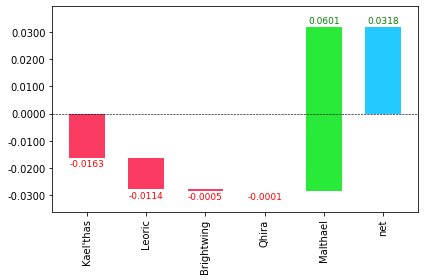

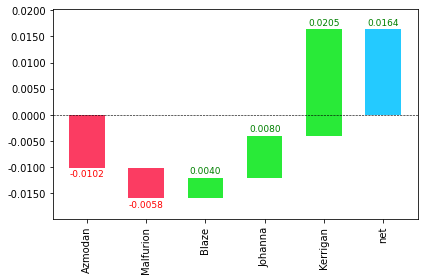

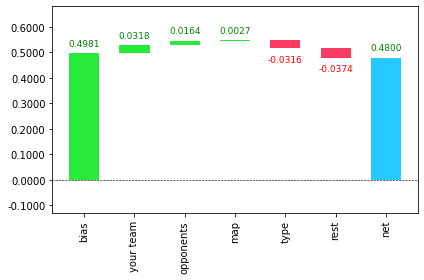

In [380]:
draw_interpretation_waterfalls(bias, prog ,rest)

In [381]:
input_row = np.asarray([hero_hot_transform(game_map = game_map, game_type=game_type, winners = your_team, losers=opponent_tea)])
prediction = m.predict(input_row)
print(prediction)

[0.48]


# XGBoost part

In [ ]:
import shap
import xgboost
#Optimize model to rmse:

In [534]:
my_model_2 = xgboost.XGBRegressor(random_state=0, learning_rate = 0.01, n_estimators = 11, max_depth=6,
                                 min_child_weight=15, subsample=0.5, colsample_bytree=0.1)
xgb_weights = pd.Series(np.linspace(0.5, 1, sample_size))

In [535]:
%time my_model_2.fit(X_train, y_train, sample_weight_eval_set = xgb_weights, verbose=False) # , early_stopping_rounds=5, eval_set=[(X_valid, y_valid)] # throws assersion error
print_score(my_model_2)

CPU times: user 526 ms, sys: 0 ns, total: 526 ms
Wall time: 200 ms
[0.4999072890854126, 0.5000035347210857, 0.00036994735118200944, -6.116221835550384e-05]


In [ ]:
#score optimized:


In [422]:
#import matplotlib.pylab as pl
#plt.rcParams["figure.figsize"] = (10, 15)
#xgboost.plot_importance(my_model_2, height=0.75, importance_type="gain") #, max_num_features=20
#pl.title("xgboost.plot_importance(model)")
#pl.show()

In [455]:
from sklearn.model_selection import GridSearchCV
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3,6,10],
        'min_child_weight': [5,10,15],
        'subsample': [0.5,0.7],
        'colsample_bytree': [0.1,0.3,0.6],
        'n_estimators' : [5,10,20,30]
        #'objective': ['reg:squarederror']
    }

    xgb_model = xgboost.XGBRegressor(sample_weight_eval_set = xgb_weights)

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'r2', #MAE
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [456]:
#hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1556 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 2456 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3233 out of 3240 | elapsed:  1.9min remaining:    0.2s


[17:51:24] WARNING: ../src/learner.cc:516: 
Parameters: { sample_weight_eval_set } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  1.9min finished


{'colsample_bytree': 0.1,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 15,
 'n_estimators': 10,
 'subsample': 0.5}

Fitting 5 folds for each of 80 candidates, totalling 400 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.4s

CPU times: user 850 ms, sys: 44.4 ms, total: 895 ms
Wall time: 6.99 s

[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.9s finished

{'colsample_bytree': 0.1,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 15,
 'n_estimators': 11,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.6min finished

CPU times: user 3.71 s, sys: 255 ms, total: 3.96 s
Wall time: 1min 35s

{'colsample_bytree': 0.1,
 'learning_rate': 0.005,
 'max_depth': 2,
 'min_child_weight': 10,
 'n_estimators': 50,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

Fitting 5 folds for each of 960 candidates, totalling 4800 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 40.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed: 65.0min finished

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 8,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

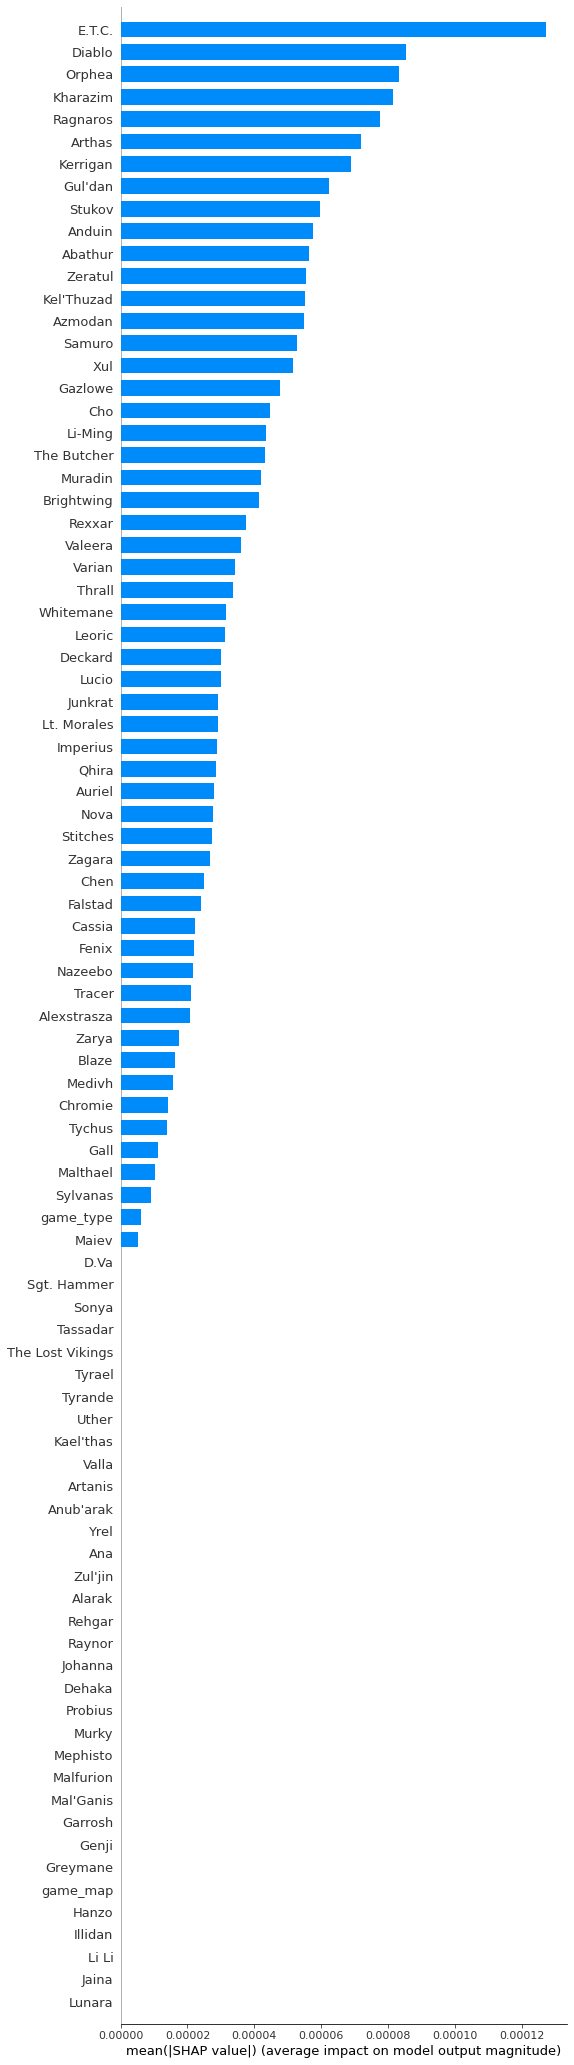

In [536]:
explainer = shap.TreeExplainer(my_model_2)
shap_values = explainer.shap_values(df_trn)
shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=X_train.shape[1]) #scrollable
#shap.summary_plot(shap_values[:,5:6], X.iloc[:, 5:6])

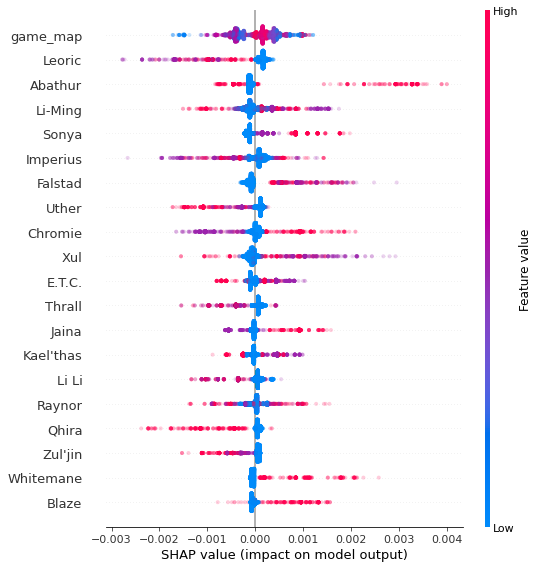

In [430]:
shap.summary_plot(shap_values, df_trn,alpha=0.2)

In [ ]:
def hyperParameterTuning_2(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01],
        'max_depth': [3,4,5,6,7,8],
        'min_child_weight': [12,15,18],
        'subsample': [0.5],
        'colsample_bytree': [0.1,0.3,0.6],
        'n_estimators' : [10,11,15]
        #'objective': ['reg:squarederror']
    }

    xgb_model = xgboost.XGBRegressor(sample_weight_eval_set = xgb_weights)

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [ ]:
hyperParameterTuning_2(X_train, y_train)

In [542]:
my_model_3 = xgboost.XGBRegressor(random_state=0, learning_rate = 0.1, n_estimators = 200, max_depth=10,
                                 min_child_weight=15, subsample=0.5, colsample_bytree=0.1)
%time my_model_3.fit(X_train, y_train, sample_weight_eval_set = xgb_weights, verbose=False) # , early_stopping_rounds=5, eval_set=[(X_valid, y_valid)] # throws assersion error
print_score(my_model_3)

CPU times: user 12 s, sys: 105 ms, total: 12.1 s
Wall time: 4.44 s
[0.4702395722085011, 0.5058889614845381, 0.11549821625951306, -0.02374270220732977]


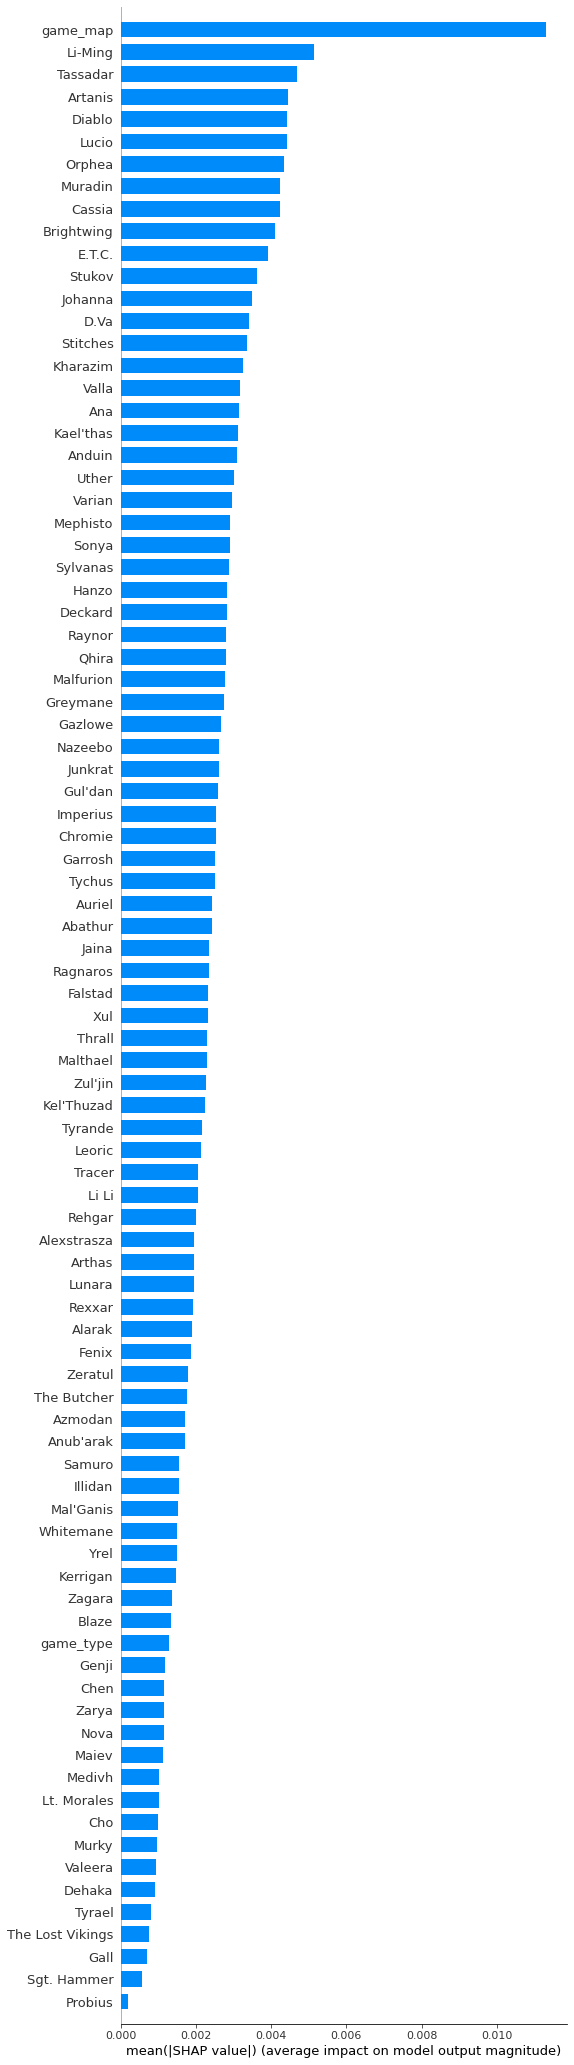

In [543]:
explainer = shap.TreeExplainer(my_model_3)
shap_values = explainer.shap_values(df_trn)
shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=X_train.shape[1]) #scrollable
#shap.summary_plot(shap_values[:,5:6], X.iloc[:, 5:6])

In [431]:
shap.initjs()

In [432]:
#to visualize single prediction with XGBoost use: shap:  https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html
#shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])
#input_row = np.asarray([hero_hot_transform(game_map = game_map, game_type=game_type, winners = winners, losers=losers)])
row_input = 1564
#feat_filter = X_train.iloc[row_input,:].columns[(df == 1).any(axis=0)]
features = X_train.iloc[row_input,:]
feature_names = X_train.columns
shap.force_plot(explainer.expected_value, shap_values=shap_values[row_input,:], features=features,feature_names=feature_names,text_rotation=-45)
#How to show the concrete game??? output changes when shap_values[] indexer is changed... but does it input new vals? How to omit zeroes?

In [433]:
def force_plot_pred_filtered(expected_value, input_row):
    pred_shap_values = explainer.shap_values(input_row)[0]
    feature_names = input_row.columns
    features = input_row.iloc[0,:]
    
    shaps_ziped = list(zip(pred_shap_values, features, feature_names))
    shaps_ziped.sort(key=lambda t: t[0], reverse=True)
    
    shaps_filtered = [(s, i, n) for (s, i, n) in shaps_ziped if i > 0]
    rest_shaps_val_total = sum([s for (s, i, n) in shaps_ziped if i == 0])
    
    shaps_filtered.append((rest_shaps_val_total, 0, "Other"))
    
    shap_v_filt = np.array([s for (s, i, n) in shaps_filtered])
    feat_filt = [i for (s, i, n) in shaps_filtered]
    names_filt = [n for (s, i, n) in shaps_filtered]

    return [(n,s) for (s, i, n) in shaps_filtered], shap.force_plot(expected_value, shap_values=shap_v_filt, features=feat_filt, feature_names=names_filt)

In [434]:
input_row = pd.DataFrame(hero_hot_transform(game_map = game_map, game_type=game_type, winners = your_team, losers=opponent_tea)).transpose()
vals, plot = force_plot_pred_filtered(explainer.expected_value, input_row)
print(vals)
plot

[('Blaze', 0.00074289436), ("Kael'thas", 0.0005829922), ('game_map', 0.00015417402), ('Malthael', 1.3719521e-05), ('Azmodan', 0.0), ('Brightwing', 0.0), ('Johanna', 0.0), ('Kerrigan', 0.0), ('Malfurion', 0.0), ('game_type', 0.0), ('Leoric', -0.0002958053), ('Qhira', -0.0011448754), ('Other', 7.392804764094763e-05)]


In [546]:
prediction = my_model_3.predict(input_row)
print(prediction)

[0.56372]


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


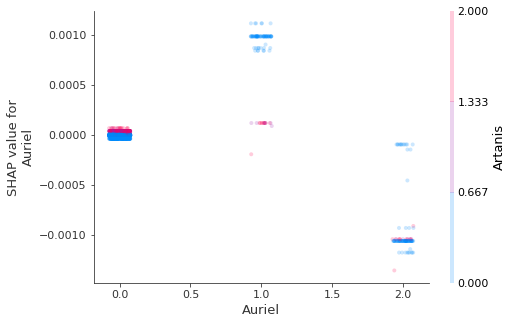

In [436]:
#this doesnt show anything usefull..
slice_size = int(sample_size / 2)
shap.dependence_plot("Auriel", shap_values[slice_size:], df_trn[slice_size:], display_features=X_train, x_jitter = 0.15, alpha = 0.2)

# XGBoost model export for API

Save model into a file. Extention will be concidered the type of the model if needed later.

In [547]:
my_model_3.save_model("exports/model_1.xgboost")

In [438]:
#input_row = pd.DataFrame(hero_hot_transform(game_map = game_map, game_type=game_type, winners = your_team, losers=opponent_tea)).transpose()
#print(input_row)

Then save categories and feature names into separate csv files, becaus emodel does not retain them.

In [439]:
feature_names = dict(enumerate(X_train.columns))
game_map_cats = dict(enumerate(df_mixed['game_map'].cat.categories))
game_type_cats = dict(enumerate(df_mixed['game_type'].cat.categories))
hero_name_cats = dict(enumerate(df_mixed['winnerA'].cat.categories))

In [440]:
import csv
def save_dict(file_name, dict_obj):
    w = csv.writer(open(file_name, "w+"))
    for key, val in dict_obj.items():
        w.writerow([key, val])

In [441]:
save_dict("exports/feature_names.csv", feature_names)
save_dict("exports/game_map_cats.csv", game_map_cats)
save_dict("exports/game_type_cats.csv", game_type_cats)
save_dict("exports/hero_name_cats.csv", hero_name_cats)

In [442]:
m_names = pd.read_csv("exports/game_map_cats.csv",header=None, index_col=0, squeeze=True).to_dict()
gt_names = pd.read_csv("exports/game_type_cats.csv",header=None, index_col=0, squeeze=True).to_dict()

m_names_swapped = dict([(value, key) for key, value in m_names.items()])
gt_names_swapped = dict([(value, key) for key, value in gt_names.items()])

Finally, prepair a transform function for API input.

In [443]:
def hero_hot_transform_xgb(game_map = '', game_type = 'UnrankedDraft', winners = [], losers = [], bans = []):
    new_row = pd.Series(index = hero_names, dtype = 'int8')
    for x in hero_names:
        if x in winners:
            new_row[x] = 2
        if x in losers:
            new_row[x] = 1
    game_map_index = m_names_swapped[game_map]
    game_type_index = gt_names_swapped[game_type]        

    new_row = new_row.append(pd.Series([game_map_index, game_type_index], index = ['game_map','game_type']))
    return new_row

In [444]:
print("DONE")

DONE
